<img src='logo.png' style='display: block;height: 61px;float: left;padding: .75rem 1.25rem;'>

# Prueba 1: Análisis de Sentimientos de Twitter

A continuación se presenta un problema clásico en el análisis de texto: Extraer el sentimiento
asociado a un texto.

Para esto, utilizaremos una base de datos provenientes de CrowdFlower.
El objetivo general de esta prueba es alcanzar el mejor desempeño posible para clasificar si un
tweet es positivo o negativo.

Para medir el desempeño, se evaluará con un conjunto de datos del cuál no tendrán acceso. De
esta manera evitaremos que los modelos aprendan información sobre el conjunto de validación.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook, archivos
auxiliares y csv).
* Una vez terminada la prueba, comprime la carpeta y sube el .zip a la sección
correspondiente.

## Objetivos

Para alcanzar el objetivo general, su trabajo se puede desagregar en los siguientes puntos:

1. Generar un análisis exploratorio sobre los datos contenidos en el DataFrame, considerando
palabras más comunes y distribución de las clases en el vector objetivo.

2. Preprocesamiento de Texto:
* Para trabajar adecuadamente con texto, debemos preprocesar y posteriormente representar cada oración como un conjunto de características.
* Para preprocesar los tweets, debemos transformarlos a lower case. Un problema recurrente en el análisis de texto es la alta ocurrencia de palabras comunes. Se recomienda eliminarlas mediante la declaración de stopwords. Para generar la exclusión de stopwords, podemos utilizar la librería `nltk` (Natural Language ToolKit) y descargar los stopwords con la siguiente instrucción.

import nltk

nltk.download('stopwords')

* Puede refinar los atributos a capturar mediante el proceso de **lemantización** (la reducción de variadas palabras con un tronco léxico común; ejemplo: Organización, Organiza, y Organizado presentan `organi_` como tronco léxico en comúmn) o **Stemming** (la reducción de una palabra a una expresión generalizable). Cabe destacar que ésta última carece de análisis morfológico del lenguaje.

* Posterior a la refinación y preprocesamiento de las palabras, podemos representar cada oración en una matriz (o corpus) que permitirá reflejar la cantidad de ocurrencias de w1 palabra en un registro. Para ello, pueden hacer uso de las librerías de preprocesamiento `sklearn.feature_extraction.text.CountVectorizer` o `sklearn.feature_extraction.text.TfidfVectorizer` . De esta manera, tendremos un conjunto de características es mediante la frecuencia de ocurrencia de una palabra o término en el texto.

## Preliminares

Una sección llamada Preliminares donde se realiza la descripción del problema y objetivos, así
como explicar cómo implementarán su solución. Debe considerar qué criterios de optimización y
métricas de desempeño.

* En este problema buscaremos clasificar con la mayor certeza posible el sentimiento que presenta un texto escrito mediante la plataforma twitter. Esto lo lograremos mediante el analisis de las palabras más repetidas en las publicaciones y como estas se asocian a un determinado sentimiento. Para esto realizaremos un procesamiento del texto de cada tweet, en donde extraeremos ciertas caracteristicas, como números, simbolos y puntuaciones, para lograr homogeneizar el contenido.
* Generaremos división de muestra para comparar los datos predichos con un nuevo conjunto de datos al cual no tendremos acceso. De esta manera no estaremos obteniendo información desde un conjunto de datos de validación.
* Nuestro vector objetivo para este problema sera un recodificación del atributo sentiment, el cual esta compuesto por 13 variables. A partir de estas 13 observaciones procederemos a clasificarlas entre Negativas y Positivas. En el caso que el sentimiento sea nutral, procederemos a reliazar una clasificación aleatoria entre Positiva o Negativa.
* Cuando se tenga el texto preprocesado y la muestra ya dividida, procederemos a implementar una busqueda de grilla en donde implementaremos distintos modelos con el fin de evaluar cual de ellos sera el que presente la mejor metrica de desempeño, para ellos implementaremos los siguientes modelos:
    * Naïve Bayes, `sklearn.naive_bayes.MultinomialNB`, sin modificar hiperparametros.
    * un modelo Regresión logística, ` sklearn.linear_model.LogisticRegression`
    * un modelo Árboles de decisión, `sklearn.tree.DecisionTreeClassifier`, con los siguientes hiperparametros:
        * 'min_samples_split': np.linspace(0.1, 1.0, 10)
        * 'criterion': ['gini', 'entropy']
        * 'max_depth': np.linspace(1, 32, 32)
        * 'min_samples_leaf': np.linspace(0.1, 0.5, 10)
        * 5 validaciones cruzdas
    * un modelo Clasificador con soporte vectorial con un kernel, `rbf.sklearn.svm.SVC`, con los siguients hiperparametros:
         * (kernel='rbf',
         * param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
         * 'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
         * 2 Validaciones Cruzadas
    * un modelo RandomForestClassifier, `RandomForestClassifier`, con los siguientes hiperparametros:
        * max_features=None
        * n_estimators=100 
        * oob_score = True
* Las metricas a utilizar para este ejercicio seran: precision, recall, F1-Score, roc_auc_score, roc_curve

## Aspectos computacionales

> Se utilizan librerías bases para el tratamiento de datos y algunos aspectos básicos de cálculo y gráficos.

In [34]:
# Se importa libreria para el manejo de bases de datos
import pandas as pd
# Se importa libreria para el manejo de operaciones de cálculo
import numpy as np
# Se importa libreria para el manejo de gráficos
import matplotlib.pyplot as plt
# Se importa libreria para manejo de funciones estadisticas y probabilidades
import seaborn as sns
# Librería para visualizar patrones de datos perdidos
import missingno as msngo
# Se importa libreria para el menejo de warning
import warnings
# Se importa libreria para el trabajo de expresiones reguilares
import re
# Se importa librería para el trabajo con string
import string

> Definimos algunos aspectos de ambiente y valores por defecto de visualización.

In [35]:
# Por defecto, matplotlib crea una figura en una ventana separada.
# podemos hacer que las figuras aparezcan en línea dentro del notebook; lo hacemos ejecutando:
%matplotlib inline
# Se ignoran los warning para evitar suciedad en la ejecución
warnings.filterwarnings(action='ignore')
# Se define el estilo de gráficos a usar
plt.style.use('seaborn-pastel')
# Se define el tamaño de los paños de los gráficos por defecto
plt.rcParams['figure.figsize'] = (14, 8)
# Dado que vamos a supervisar datos no limitaremos la cantidad de columnas a mostrar 
# en el despliegue del dataframe
pd.options.display.max_columns = None

> Se utilizan librerías de __sklear__ para resolver el problema desde el enfoque de machine learning

In [36]:
# Método para el manejo de ocurrencias de palabras en texxto
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Método de ensamble arbol de decisión para clasificación 
from sklearn.tree import DecisionTreeClassifier
# Método de clasificación mediante la maximización de margen de clases.
from sklearn.svm import SVC
# Método que implementa la regresión logistica
from sklearn.linear_model import LogisticRegression
# Método que implementa Bayes ingenuo para el caso dos clases y multiclase.
from sklearn.naive_bayes import MultinomialNB
# Método para Asignación Latente de Dirichlet (ALD)
from sklearn.decomposition import LatentDirichletAllocation
# Método de mezcla de Gaussianas
from sklearn.mixture import GaussianMixture
# Método de KMeans
from sklearn.cluster import KMeans
# Método de ensamble
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
# Métricas para evaluar modelos de clasificación
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
# Métodos de selección de muestras
from sklearn.model_selection import GridSearchCV, train_test_split
# Metodo para el procesamiento de los datos en una tuberias
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

> Se utilizan librerias especificas para el procesamiento de texto

In [37]:
import nltk
from nltk.stem import WordNetLemmatizer

> Se utiliza la librería __pickle__ que contiene la función dump, que permite guardar el modelo desarrollado. 

In [38]:
# Método para hacer dump del modelo y objetos
import pickle

> Se utiliza <strong>librería propia</strong> que continen funciones auxiliares, necesarias para el desarrollo de desafíos.

In [39]:
# Se importa libreria con funciones auxiliares
import ancilliary_funcs as afx

> Se utiliza <strong>librería helpers.py</strong> que continen funciones auxiliares, necesarias para el desarrollo de desafíos.

In [40]:
import helpers as hlp

## Análisis Exploratorio

Una sección llamada Análisis Exploratorio donde se generará un análisis descriptivo
considerando el tipo de variables (desde el punto de vista estadístico así como computacional).
Esta sección debe considerar medidas univariadas/ frecuencias, datos perdidos y gráficos
distributivos sobre las variables a analizar. A partir de ésta se debe clarificar la estrategia de
preprocesamiento (datos perdidos, recodificaciones).

In [8]:
df = pd.read_csv('text_emotion.csv')

In [9]:
# obtenemos información del df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
tweet_id     40000 non-null int64
sentiment    40000 non-null object
author       40000 non-null object
content      40000 non-null object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [10]:
# preguntamos por las dimensiones del df
df.shape

(40000, 4)

* La base cuenta con 40000 registros y 4 atributos

In [11]:
# inspeccionamos el df
df.head(10)

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ..."
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?


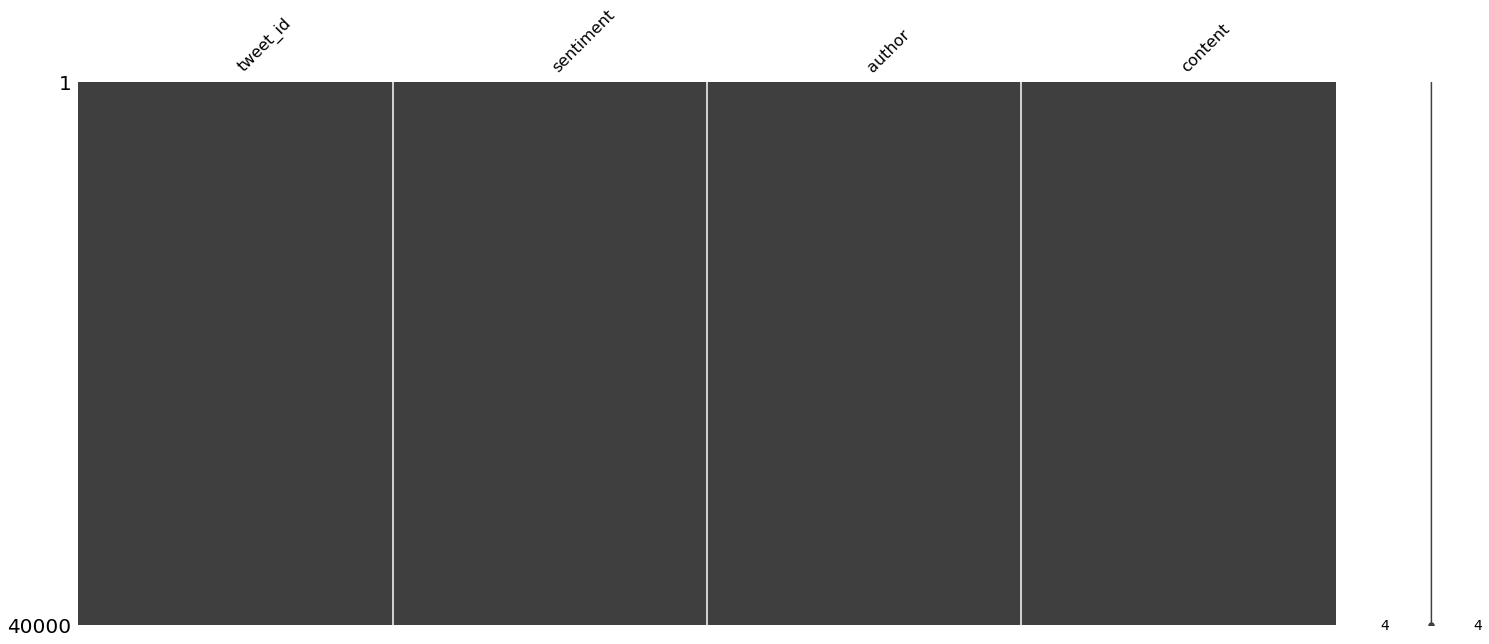

In [12]:
# realizamos un grafico para clarificar si se cuenta con datos perdidos
msngo.matrix(df)

* Se observa que la base no cuenta con datos perdidos, por lo que no sera necesario realizar alguna accion para mejorar ese aspecto.

> Realizamos un grafico donde contaremos cuales son los sentimientos ordenados de mayor a menor frecuencia

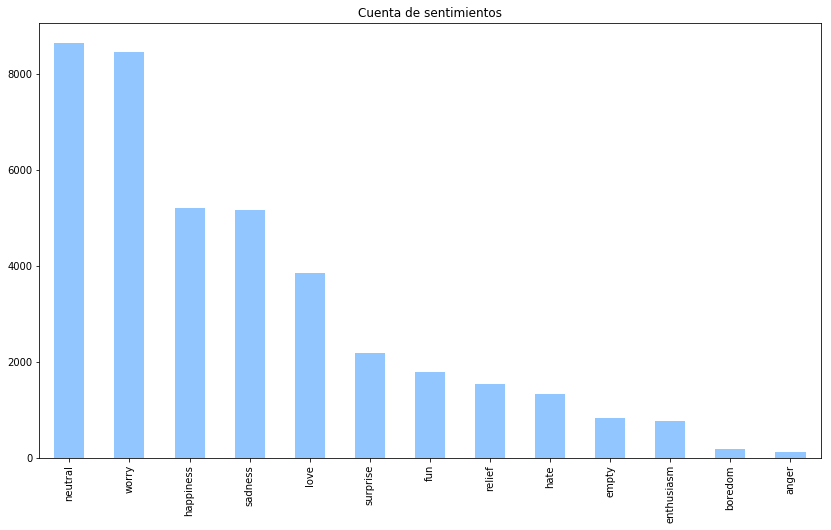

In [13]:
df['sentiment'].value_counts().plot(kind='bar', title="Cuenta de sentimientos")

* Observamos que el atributo sentiment cuenta con 13 categorias diferentes. El sentimiento con mayor cantidad en la muestra es neutral. Procederemos a reclasificar neutral para obtener una clasificación equiprobable tanto positiva como negativa. 

In [14]:
df['sentiment'].value_counts('%')

neutral       0.215950
worry         0.211475
happiness     0.130225
sadness       0.129125
love          0.096050
surprise      0.054675
fun           0.044400
relief        0.038150
hate          0.033075
empty         0.020675
enthusiasm    0.018975
boredom       0.004475
anger         0.002750
Name: sentiment, dtype: float64

* Si obtenemos los porcentajes de la ditribución de sentimientos dentro de sentiment, observamos que neutral corresponde al 22% del total de muestras, Negativa acumula el 40% del total y Positiva se lleva el 38% restante.

* Como sentiment sera nuestro vector objetivo, más adelante procederemos a reclasificar el vector para lograr trabajar el ejercicio de una mejor manera. Esto lo clasificaremos en 2 grupos: Positiva o Negativa

In [15]:
# exploramos sobre los autores de los tweets, para ver si existe alguien que se destaque por sobre manera en las 
# publicaciones, lo cual no sucede
df['author'].value_counts()

MissxMarisa       23
ChineseLearn      22
erkagarcia        19
MiDesfileNegro    19
lost_dog          18
                  ..
thefore            1
AngieOzuna         1
jun6lee            1
Jazzable           1
KaliLekkas         1
Name: author, Length: 33871, dtype: int64

In [16]:
len(df['author'].unique())

33871

* Vemos que en total existen 33871 diferentes autores de tweets del universo de 40000 a analizar, lo cual nos indica que no existe un solo usuario que este realizando la mayoria de publicaciones. De esta manera podemos descartar la presencia de bots que se dedican a realizar publicaciones de manera sesgada de acuerdo a un interes personal del creador del mismo.

## Feature Engineering

Una sección llamada Feature Engineering donde se declarará todas las recodificaciones y
transformaciones a realizar

In [11]:
# procedemos a llevar a minuscula todo el texto de la publicación
df['content_lower'] = list(map(lambda x: x.lower(), df['content']))

In [12]:
df['content_lower'].head()

0    @tiffanylue i know  i was listenin to bad habi...
1    layin n bed with a headache  ughhhh...waitin o...
2                  funeral ceremony...gloomy friday...
3                 wants to hang out with friends soon!
4    @dannycastillo we want to trade with someone w...
Name: content_lower, dtype: object

In [19]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camiloalarcon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/camiloalarcon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# creamos una función que extrae patrones de texto que deseamos quitar de las publicaciones
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt  

In [14]:
# removemos encabezados de twitter (@usuario)
df['content_lower'] = np.vectorize(remove_pattern)(df['content_lower'], "@[\w]*")

In [15]:
# removemos caracteres especiales, puntuación, números
df['content_lower'] = df['content_lower'].str.replace("[^a-zA-Z#]", " ")

In [16]:
# removemos palabras con 3 letras o menos
df['content_lower'] = df['content_lower'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [17]:
# volvemos a imprimir un encabezado del df para observar los cambios luego del preprocesamiento, los cambios 
# se incorporan en una nueva columna para fines comparativos, una vez finalizado todo el procesamiento de texto
# se eliminara la columna original
df.head()

,tweet_id,sentiment,author,content,content_lower
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,know listenin habit earlier started freakin part
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,layin with headache ughhhh waitin your call
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants hang with friends soon
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,want trade with someone houston tickets will


* Observamos que el contenido del tweet preprocesado cambia en relación al contenido original, ya no se observan mayusculas, signos ni simbolos

In [18]:
lemmatizer = WordNetLemmatizer()
def lemmatization(text):
    arr_words = text.split(' ')
    arr_words_lem = [lemmatizer.lemmatize(x, "v") for x in arr_words]
    return ' '.join(arr_words_lem)

In [19]:
df['content_lower_lem'] = df['content_lower'].apply(lemmatization)

In [20]:
# Revisamos que se haya producido la lemmatization
df.head(10)

,tweet_id,sentiment,author,content,content_lower,content_lower_lem
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,know listenin habit earlier started freakin part,know listenin habit earlier start freakin part
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,layin with headache ughhhh waitin your call,layin with headache ughhhh waitin your call
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,funeral ceremony gloomy friday,funeral ceremony gloomy friday
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants hang with friends soon,want hang with friends soon
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,want trade with someone houston tickets will,want trade with someone houston ticket will
5,1956968477,worry,xxxPEACHESxxx,Re-pinging @ghostridah14: why didn't you go to...,pinging didn prom didn like friends,ping didn prom didn like friends
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ...",should sleep thinking about friend want marrie...,should sleep think about friend want marry dam...
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down,hmmm http djhero down,hmmm http djhero down
8,1956969035,sadness,nic0lepaula,@charviray Charlene my love. I miss you,charlene love miss,charlene love miss
9,1956969172,sadness,Ingenue_Em,@kelcouch I'm sorry at least it's Friday?,sorry least friday,sorry least friday


In [21]:
df_encode = df.drop(columns=['content_lower', 'content'])

In [22]:
# generamos una recodificación de sentiment y agrupamos según sea positiva o negativa
df_encode['sentiment_recod'] = df_encode['sentiment']
df_encode['sentiment_recod'] = df_encode['sentiment_recod'].replace(['happiness','love','surprise','fun','relief','enthusiasm'], 'Positiva')
df_encode['sentiment_recod'] = df_encode['sentiment_recod'].replace(['worry','sadness','hate','empty','boredom','anger'], 'Negativa')
df_encode['sentiment_recod'] = df_encode['sentiment_recod'].apply(lambda x: np.random.choice(['Negativa', 'Positiva']) if x=='neutral' else x)

In [23]:
# comprobamos que la recodificación del vector objetivo sea correcta
df_encode['sentiment_recod'].value_counts()

Negativa    20340
Positiva    19660
Name: sentiment_recod, dtype: int64

* La suma de observaciones positiva y Negativa nos da 40000 observaciones y se observa que la clase queda balanceada

In [24]:
# binarizamos el vector objetivo y lo agregamos a df_encode
df_encode['sentiment_recod_bin'] = np.where(df_encode.sentiment_recod == 'Positiva',1,0)

In [34]:
df_encode.head()

,tweet_id,sentiment,author,content_lower_lem,sentiment_recod,sentiment_recod_bin
0,1956967341,empty,xoshayzers,know listenin habit earlier start freakin part,Negativa,0
1,1956967666,sadness,wannamama,layin with headache ughhhh waitin your call,Negativa,0
2,1956967696,sadness,coolfunky,funeral ceremony gloomy friday,Negativa,0
3,1956967789,enthusiasm,czareaquino,want hang with friends soon,Positiva,1
4,1956968416,neutral,xkilljoyx,want trade with someone houston ticket will,Positiva,1


In [25]:
df_encode['sentiment_recod_bin'].value_counts('%')

0    0.5085
1    0.4915
Name: sentiment_recod_bin, dtype: float64

* Tenemos 51% de tweets asociados al sentimiento Negativo y un 49% de tweets asociados a un sentimiento Positivo.

In [26]:
# creacion del bag of words
# instanciamos un objeto
count_vectorizer = CountVectorizer(stop_words='english', max_features = 180976)
# implementamos los pasos fit y transform
transformed_feats = count_vectorizer.fit_transform(df_encode['content_lower_lem'])
# extraemos tokens (palabras)
words = count_vectorizer.get_feature_names()
# extraemos frecuencia
words_count = transformed_feats.toarray().sum(axis=0)
# generamos un df con la frecuencia obtenida
df_words = pd.DataFrame({'word': words, 'count': words_count})
# obtenemos un df con las 100 palabras más repetidas
df_words_100 = df_words.sort_values(by='count', ascending=False).head(100)

In [42]:
df_words_100.transpose()

,10959,8361,23312,11893,12223,16631,9714,21019,20762,20920,11350,9011,20644,12526,13296,22602,16834,7099,13596,14216,9518,12129,4130,14025,22657,23153,8564,21644,13551,9595,8841,18851,21073,22537,21091,19226,17372,14178,11716,1985,8359,23607,22787,22780,15446,21637,5479,19570,17905,17973,21545,7458,15798,5088,5827,1362,9080,21430,1965,19897,11984,12108,20518,19176,11988,20753,9139,9173,20963,11862,20089,16696,12894,18598,15586,2418,2562,22598,13634,4436,8781,20334,7720,9670,9807,6483,9673,12182,16813,9291,8727,7711,16808,16220,7705,12821,22544,4965,8207,7236
word,just,good,work,like,love,quot,http,today,think,time,know,happy,thank,make,miss,want,really,feel,mother,night,home,look,come,need,watch,wish,great,twitter,morning,hope,haha,sleep,tomorrow,wait,tonight,sorry,right,nice,leave,better,gonna,yeah,weekend,week,people,twitpic,didn,start,say,school,tweet,follow,play,days,dont,awesome,hate,try,best,suck,little,long,tell,soon,live,thing,head,hear,tire,life,sure,rain,mean,sick,phone,bore,break,wanna,movie,cool,guy,talk,friends,hours,hurt,enjoy,house,lose,ready,help,guess,friend,read,pretty,friday,maybe,wake,damn,girl,finally
count,3210,2309,2208,2071,1952,1855,1838,1664,1601,1582,1507,1484,1472,1448,1392,1387,1279,1273,1227,1124,1077,1046,1044,1019,949,889,877,868,860,843,807,755,723,721,697,695,664,624,621,613,604,602,591,589,544,525,517,514,510,509,497,491,490,483,482,478,467,464,449,447,441,437,435,432,427,427,403,401,398,385,384,383,380,376,371,370,367,366,363,361,359,358,356,349,347,337,330,324,322,320,318,316,315,313,312,309,309,308,306,305


In [43]:
df_words.shape

(23928, 2)

* Vemos que en total la matriz de words posee 23928 registros, lo cual nos indica el número máximo de diferentes palabras que podremos asociar a un sentimiento en particular, positivo o negativo

## Modelación

Una sección llamada Modelación, donde se implementará una solución analítica que aumente
las métricas de desempeño. Se solicitan por lo menos 5 modelos predictivos. Cada modelo
predictivo debe tener una reseña sobre el por qué se diseño de esa forma.

In [44]:
df_encode.head()

,tweet_id,sentiment,author,content_lower_lem,sentiment_recod,sentiment_recod_bin
0,1956967341,empty,xoshayzers,know listenin habit earlier start freakin part,Negativa,0
1,1956967666,sadness,wannamama,layin with headache ughhhh waitin your call,Negativa,0
2,1956967696,sadness,coolfunky,funeral ceremony gloomy friday,Negativa,0
3,1956967789,enthusiasm,czareaquino,want hang with friends soon,Positiva,1
4,1956968416,neutral,xkilljoyx,want trade with someone houston ticket will,Positiva,1


In [113]:
def roc_graph(y_test, y_hat):
    false_positive , true_positive , threshold = roc_curve(y_test,y_hat[:,1])
    plt.plot(false_positive,true_positive,lw = 1)
    plt.plot([0,1], linestyle='--', lw=1, color='tomato')
    plt.ylabel('Verdaderos Positivos')
    plt.xlabel('Falsos Positivos')


In [27]:
X = df_encode['content_lower_lem']
y = df_encode['sentiment_recod_bin']
y2 = df_encode['sentiment_recod']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33, random_state=558)

> * Generamos nuestro primer modelo **MultinomialNB**, en donde utilizaremos un pipeline para primero generar un objeto countvectorizer y posteriormente implementamos el modelo

In [29]:
pipelined_model_nb = Pipeline(
    [
        ('countvec', CountVectorizer(stop_words='english', max_features = 23928)),
        ('multinom_nb', MultinomialNB())
    ]
)

In [30]:
model_nb = pipelined_model_nb.fit(X_train, y_train)

In [42]:
# utilizamos nuestros datos de entrenamiento
pr_class_nb = model_nb.predict(X_test)
pr_class_proba_nb = model_nb.predict_proba(X_test)

In [43]:
# generamos la matrix de confusion
confusion_matrix(y_test, pr_class_nb)/len(y_test)

array([[0.35613636, 0.15143939],
       [0.18984848, 0.30257576]])

In [45]:
# generamos las metricas
print(classification_report(y_test, pr_class_nb))

              precision    recall  f1-score   support

           0       0.65      0.70      0.68      6700
           1       0.67      0.61      0.64      6500

   micro avg       0.66      0.66      0.66     13200
   macro avg       0.66      0.66      0.66     13200
weighted avg       0.66      0.66      0.66     13200



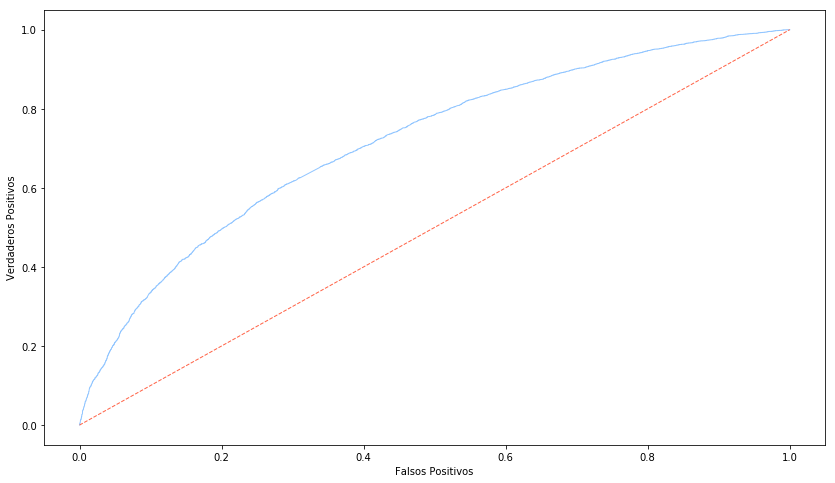

In [115]:
roc_graph(y_test, pr_class_proba_nb)

In [61]:
pickle.dump(model_nb, open('multinomialnb.sav','wb'))

> * Para nuestro primer modelo implementado, vemos que mejora la metrica de desempeño, logrando predecir en un 68% los tweets asociados a un sentimiento negativo y en un 64% los sentimientos asociados como positivos. En general el modelo logra predecir con un 66% de exactitud si un tweet esta asociado a un sentimiento negativo o un sentimiento positivo, lo cual señala que nuestro modelo mejora en un 15% las predicciones correctas respecto a un clasificador aleatorio 0,5%

In [178]:
%%time
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
nbgs = GridSearchCV(MultinomialNB(),
                         {'alpha': alphas, 
                          'fit_prior':[True,False], 
                          'class_prior':[None]},
                          cv=5).fit(X_tr_2, y_tr_2)

CPU times: user 1.8 s, sys: 186 ms, total: 1.98 s
Wall time: 2.05 s


In [179]:
# utilizamos nuestros datos de entrenamiento
nbgs_pr_class = nbgs.predict(X_te_2)
nbgs_pr_class_proba = nbgs.predict_proba(X_te_2)

In [180]:
# generamos las metricas
print(classification_report(y_te_2, nbgs_pr_class))

              precision    recall  f1-score   support

           0       0.65      0.70      0.68      6700
           1       0.67      0.62      0.64      6500

   micro avg       0.66      0.66      0.66     13200
   macro avg       0.66      0.66      0.66     13200
weighted avg       0.66      0.66      0.66     13200



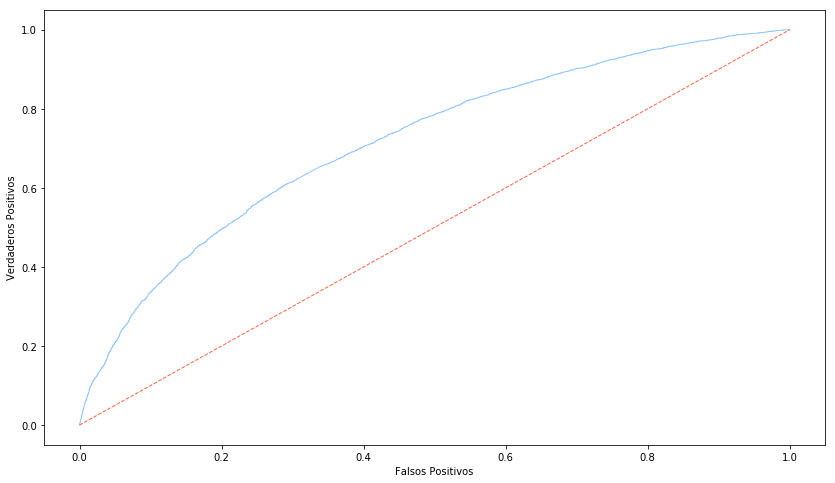

In [181]:
roc_graph(y_te_2, nbgs_pr_class_proba)

In [182]:
pickle.dump(nbgs, open('nbgs_cv.sav','wb'))

> * En el modelo implementado con busqueda de grilla y 5 validaciones cruzadas para MultinomialNB, vemos que el modelo clasifica de manera correcta el 68% de tweets negativos y un 64% los tweets positivos.

> * En general el modelo clasifica de manera correcta el 66% de los tweets, lo cual representa una mejora de un 16% con respecto a un clasificador aleatorio.

> * En comparación entre los modelos sin busqueda de grilla y sin validaciones cruzadas, vemos que el modelo obtiene las mismas metricas de clasificación, esto puede ser indicio de que los hiparparametros no fueron tuneados de la mejor manera y se podrian mejorar en futuras iteraciones.

> Generamos nuestro segundo modelo **Regresión Logistica**

In [62]:
logreg = LogisticRegression()

In [63]:
y2 = df_encode['sentiment_recod']

In [64]:
X_tr, X_te, y_tr, y_te = train_test_split(transformed_feats, y2, test_size=0.33, random_state=558)

In [65]:
logreg.fit(X_tr, y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [66]:
y_pred = logreg.predict(X_te)

In [117]:
y_pred_proba = logreg.predict_proba(X_te)

In [67]:
confusion_matrix(y_te, y_pred)/len(y_te)

array([[0.34924242, 0.15833333],
       [0.18636364, 0.30606061]])

In [68]:
# generamos las metricas
print(classification_report(y_te, y_pred))

              precision    recall  f1-score   support

    Negativa       0.65      0.69      0.67      6700
    Positiva       0.66      0.62      0.64      6500

   micro avg       0.66      0.66      0.66     13200
   macro avg       0.66      0.65      0.65     13200
weighted avg       0.66      0.66      0.65     13200



In [70]:
pickle.dump(logreg, open('logisticregression.sav','wb'))

> Vemos que nuestro segundo modelo de regresión logistica logra predecir en un 67% a los tweets negativos y en un 63% a los tweets positivos. El modelo en general logra predecir de manera correcta en un 65%, lo que representa una mejora en la clasificación de un 15% con respecto a nuestro clasificador aleatorio (0,5%)

In [144]:
%%time
logreg_gscv = GridSearchCV(LogisticRegression(),
                           {"C":np.logspace(-3,3,7), 
                            "penalty":["l1","l2"]}
                           ,cv=5).fit(X_tr, y_tr)

CPU times: user 59.1 s, sys: 615 ms, total: 59.7 s
Wall time: 34.7 s


In [145]:
y_pred_lrcv = logreg_gscv.predict(X_te)

In [146]:
y_pred_proba_lrcv = logreg_gscv.predict_proba(X_te)

In [147]:
# generamos las metricas
print(classification_report(y_te, y_pred_lrcv))

              precision    recall  f1-score   support

    Negativa       0.65      0.73      0.69      6700
    Positiva       0.69      0.60      0.64      6500

   micro avg       0.67      0.67      0.67     13200
   macro avg       0.67      0.66      0.66     13200
weighted avg       0.67      0.67      0.66     13200



In [148]:
pickle.dump(logreg_gscv, open('logisticregression_gscv.sav','wb'))

> Si volvemos a realizar un modelo logisticregression con grid search y 5 validaciones cruzadas y modificamos ciertos hiperparametros, observamos que obtenemos una mejora en el rendimiento general del modelo en un 1% con respecto al modelo sin gridsearch.

> El desempeño en la clasificación de tweets negativos mejora en un 2%, pasando de 67% a 69%, mientras que la clasificación para tweets positivos se mantiene igual, en un 64%

> Implementamos un tercer modelo: **DecisionTreeClassifier**

In [76]:
X_tr_2, X_te_2, y_tr_2, y_te_2 = train_test_split(transformed_feats, y, test_size=0.33, random_state=558)

In [149]:
dec_tree = DecisionTreeClassifier()

In [150]:
dec_tree.fit(X_tr_2, y_tr_2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [151]:
dectree_pred_proba = dec_tree.predict_proba(X_te_2)

In [153]:
print(classification_report(y_te_2, dec_tree.predict(X_te_2)))

              precision    recall  f1-score   support

           0       0.60      0.67      0.63      6700
           1       0.61      0.54      0.57      6500

   micro avg       0.60      0.60      0.60     13200
   macro avg       0.60      0.60      0.60     13200
weighted avg       0.60      0.60      0.60     13200



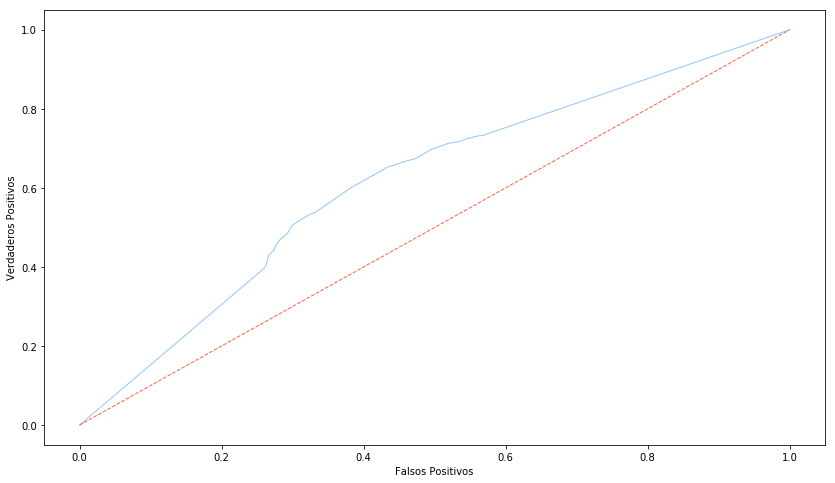

In [154]:
roc_graph(y_te_2, dectree_pred_proba)

In [155]:
pickle.dump(dec_tree, open('dec_tree.sav','wb'))

> * Si ejectuamos un modelo DecisionTreeClassifier sin realizar busqueda de grilla no modificar hiperparametros, observamos que el modelo logra clasificar de manera correcta en un 63% los tweets negativos y en un 57% los tweets positivos.

> * En general el modelo logra clasificar de manera correcta un 60% de las observaciones, lo cual mejora en un 10% el rendimiento si lo comparamos con un clasificador aleatorio.

In [77]:
%%time
dec_tree_gscv = GridSearchCV(DecisionTreeClassifier(),
                               {'min_samples_split': np.linspace(0.1,1.0,10),
                               'criterion':['gini','entropy'],
                               'max_depth': np.linspace(1,32,32),
                               'min_samples_leaf': np.linspace(0.1,0.5,10),
                               },cv=5).fit(X_tr_2, y_tr_2)

CPU times: user 6h 2min 20s, sys: 4min 4s, total: 6h 6min 24s
Wall time: 6h 19min 28s


In [80]:
dec_tree_gscv.best_params_

{'criterion': 'gini',
 'max_depth': 1.0,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1}

In [81]:
dec_tree_gscv.best_score_

0.508955223880597

In [83]:
dec_tree_gscv.best_estimator_.feature_importances_

array([0., 0., 0., ..., 0., 0., 0.])

In [120]:
dt_pred_proba = dec_tree_gscv.predict_proba(X_te_2)

In [85]:
print(classification_report(y_te_2, dec_tree_gscv.best_estimator_.predict(X_te_2)))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67      6700
           1       0.00      0.00      0.00      6500

   micro avg       0.51      0.51      0.51     13200
   macro avg       0.25      0.50      0.34     13200
weighted avg       0.26      0.51      0.34     13200



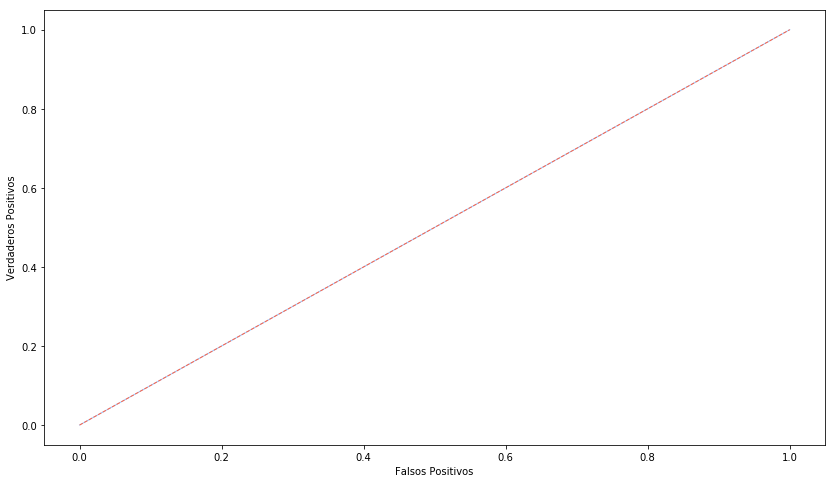

In [121]:
roc_graph(y_te_2, dt_pred_proba)

In [ ]:
pickle.dump(dec_tree_gscv, open('dec_tree_gscv.sav','wb'))

> * Luego de evaluar un tercer modelo con DesicionTreeClassifier con busqueda de grilla y modificando hiperparametros, vemos que el modelo logra evaluar las observaciones negativas con un 67% de efectividad, y vemos que para las observaciones positivas el modelo no logra clasificar ninguna observación y arroja 0%.

> * El modelo en general logra predecir de manera correcta en un 34%, lo cual comparado a nuestro clasificador aleatorio 0,5% nos indica que este modelo entrega malos resultados, esto debido a que no logra entregar resultados para la clasificación positiva de los tweets.

> * Si comparamos este modelo versus el modelo sin busqueda de grilla, vemos que el rendimiento empeora drasticamente, lo cual es un indicio de que los hiparparametros no fueron tuneados de manera correcta, lo cual produjo un detrioro del rendimiento.

> Generamos nuestro cuarto modelo **RandomForestClassifier**

In [156]:
randforest = RandomForestClassifier()

In [157]:
randforest.fit(X_tr_2, y_tr_2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [158]:
randforest_predict = randforest.predict(X_te_2)

In [159]:
randforest_predict_proba = randforest.predict_proba(X_te_2)

In [160]:
print(classification_report(y_te_2, randforest_predict))

              precision    recall  f1-score   support

           0       0.62      0.67      0.65      6700
           1       0.63      0.58      0.61      6500

   micro avg       0.63      0.63      0.63     13200
   macro avg       0.63      0.63      0.63     13200
weighted avg       0.63      0.63      0.63     13200



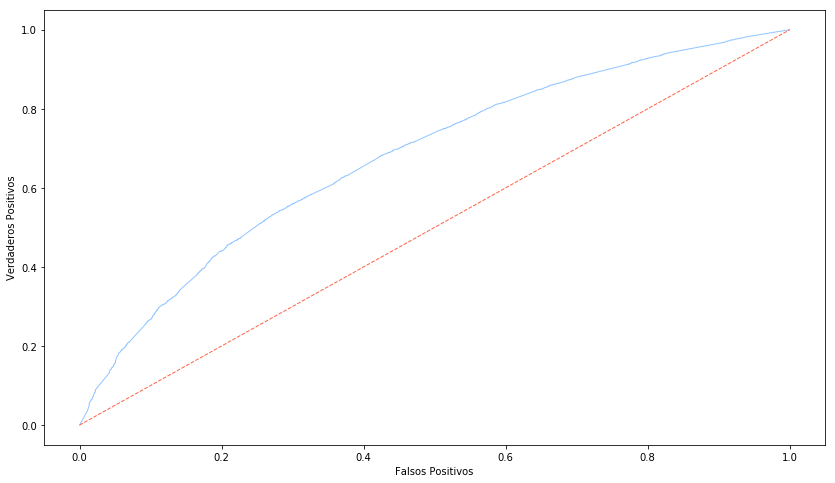

In [161]:
roc_graph(y_te_2, randforest_predict_proba)

In [162]:
pickle.dump(randforest, open('randforest.sav','wb'))

> * Si ejecutamos un modelo RandomForestClassifier sin busqueda de grilla y sin modificar hiperparametros, observamos que el modelo logra clasificar de manera correcta en un 65% los tweet negativos y en un 61% los tweets positivos.

> * En general el modelo logra predecir en un 63% de manera correcta lo cual indica una mejora de un 13% con respecto a un clasificador aleatorio.

In [169]:
%%time
model_rf_gscv = GridSearchCV(RandomForestClassifier(),
                            {'n_estimators': [200, 400],
                             'max_features': ['auto', 'sqrt', 'log2']}
                               ,cv=2).fit(X_tr_2, y_tr_2)

CPU times: user 1h 20min 16s, sys: 48.5 s, total: 1h 21min 4s
Wall time: 1h 24min 26s


In [172]:
rf_gscv_predict = model_rf_gscv.predict(X_te_2)

In [173]:
rf_gscv_predict_proba = model_rf_gscv.predict_proba(X_te_2)

In [174]:
print(classification_report(y_te_2, rf_gscv_predict))

              precision    recall  f1-score   support

           0       0.64      0.69      0.66      6700
           1       0.65      0.60      0.63      6500

   micro avg       0.65      0.65      0.65     13200
   macro avg       0.65      0.65      0.65     13200
weighted avg       0.65      0.65      0.65     13200



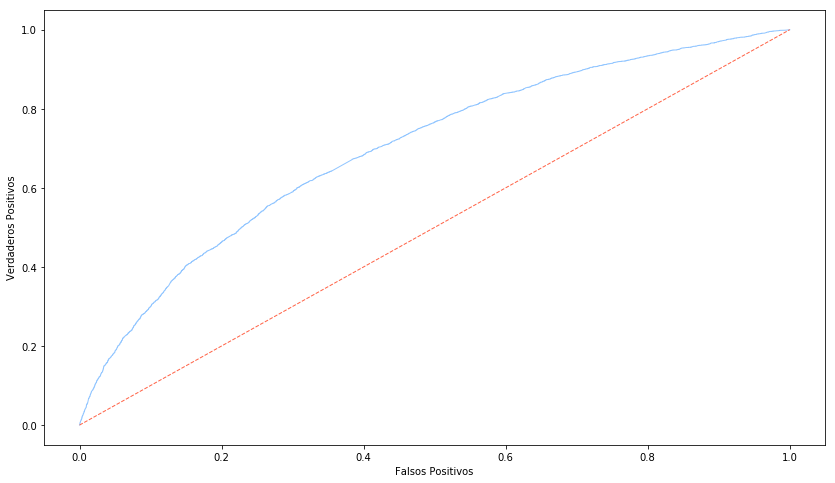

In [175]:
roc_graph(y_te_2, rf_gscv_predict_proba)

In [176]:
pickle.dump(model_rf_gscv, open('randomforest_gscv.sav','wb'))

> * El modelo RandomForestClassifier implementado con busqueda de grilla y con 2 validaciones cruzadas (por temas de costo computacional y limitaciones de hardware se evalua con solo 2 cv), logra clasificar de manera correcta un 66% los tweets negativos y en un 63% los tweets positivos.

> * En general este modelo logra clasificar de manera correcta en un 65% los tweets, lo cual es una mejora de un 15% con respecto a un clasificados aleatorio.

> * Por último, se observa que hay una mejora en el desempeño global del modelo al realizar una busqueda de grilla y modificando hiperparametros, el modelo mejora en un 2% la clasificación de tweets con respecto al modelo sin grid search y sin cv.

> Implementamos un quinto modelo **SVC**

In [187]:
svc = SVC(probability=True)

In [188]:
%%time
svc.fit(X_tr_2, y_tr_2)

CPU times: user 5min 30s, sys: 3.95 s, total: 5min 34s
Wall time: 5min 38s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [189]:
svc_predict = svc.predict(X_te_2)

In [190]:
svc_predict_proba = svc.predict_proba(X_te_2)

In [191]:
print(classification_report(y_te_2, svc_predict))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67      6700
           1       0.00      0.00      0.00      6500

   micro avg       0.51      0.51      0.51     13200
   macro avg       0.25      0.50      0.34     13200
weighted avg       0.26      0.51      0.34     13200



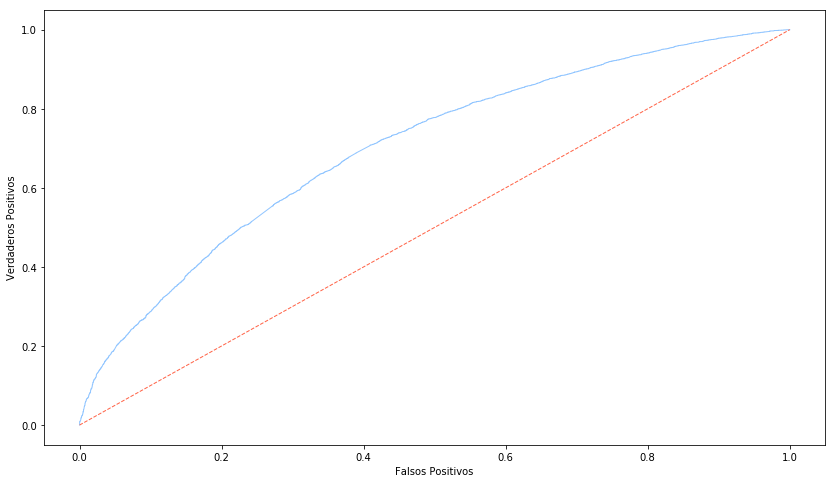

In [192]:
roc_graph(y_te_2, svc_predict_proba)

> * El modelo de SVC sin busqueda de grilla logra clasificar de manera correcta en un 67% los tweets negativos, mientras que para los tweets positivos no los logra clasificar y obtenemos un 0%

> * En general el modelo logra clasificar de manera efectiva el 34% de los tweets, lo cual muestra un desempeño aún peor que si lo comparamos con un clasificador aleatorio de 0.5%.

In [193]:
pickle.dump(svc, open('svc.sav','wb'))

In [99]:
c_param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma_param_range = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
params = {'C': c_param_range, 'gamma': gamma_param_range}

In [101]:
%%time
svccv = GridSearchCV(SVC(kernel = 'rbf', probability=True), params, cv=2)
svccv.fit(X_tr_2, y_tr_2)

CPU times: user 4h 1min 57s, sys: 5min 56s, total: 4h 7min 54s
Wall time: 4h 17min 39s


In [102]:
svc_pred = svccv.predict(X_te_2)
svc_pred_proba = svccv.predict_proba(X_te_2)

In [103]:
print(classification_report(y_te_2, svc_pred))

              precision    recall  f1-score   support

           0       0.64      0.76      0.69      6700
           1       0.69      0.56      0.62      6500

   micro avg       0.66      0.66      0.66     13200
   macro avg       0.67      0.66      0.66     13200
weighted avg       0.67      0.66      0.66     13200



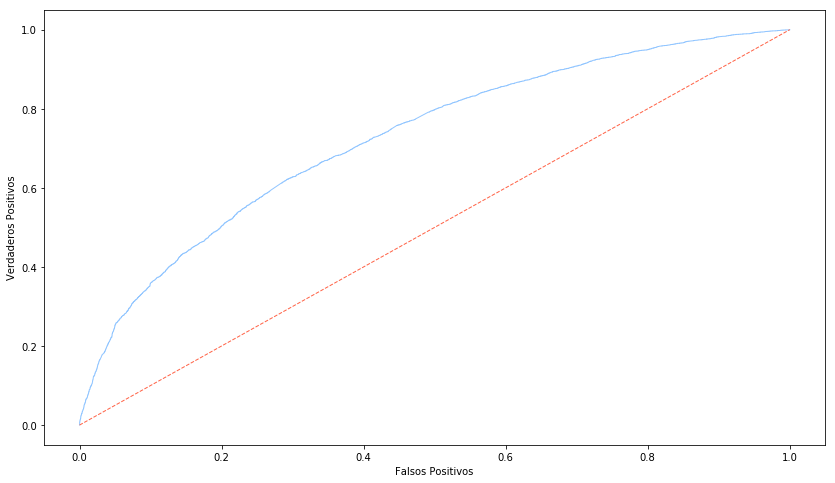

In [126]:
roc_graph(y_te_2, svc_pred_proba)

In [104]:
pickle.dump(svccv, open('svc_cv.sav','wb'))

> * Observamos que el modelo de soporte vectorial logra clasificar de manera adecuada el 69% de las observaciones negativas y en un 62% las observaciones positivas.

> * En cuanto al rendimiento general del modelo, este logra clasificar de manera correcta el 66% de las observaciones, lo cual comparado con un clasificador aleatorio mejora el rendimiento en un 16%

> * Si comparamos el rendimiento de este modelo versus el rendimiento del modelo sin busqueda de grilla, vemos que este modelo mejora de manera substancial en comparación al otro, logrando clasificar los tweets de clasificación positiva, cosa que el primer modelo no logra, por lo que la implementación de hiperparametros fue efectiva.

> Finalmente, luego de realizar 5 modelos diferentes para lograr obtener una predicción de los sentimientos asociados a cada tweet, podemos clasificar a los modelos generados según su rendimiento:

> Modelos sin modificar busqueda de grilla:

> * MultinomialNB con un 66% general
> * LogisticRegression con un 65% general
> * DecisionTreeClassifier con un 60% general
> * RandomForestClassifier con un 63% general
> * SVC con un 34% general

> Modelos con implementación de busqueda de grilla:

> * MultinomialNB con un 66% general
> * LogisticRegression con un 66% general
> * DecisionTreeClassifier con un 34% general
> * RandomForestClassifier con un 63% general
> * SVC con un 66% general

> Para finalizar se señala que se envian a competencia los modelos MultinomialNB **(nbgs_cv.sav)** y SVC **(svc_cv.sav)**, los cuales presentan el mejor rendimiento entre los 5 modelos ejecutados, ambos con busqueda de grilla.